<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_2021_aug_tabular_playground_series_aug_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import scipy
from scipy.stats import skew

In [2]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
train.shape, test.shape, submit.shape

((250000, 102), (150000, 101), (150000, 2))

In [ ]:
train['loss'].skew()  # target 라벨에 log1p씌울까 

1.4653191365369271

Text(0.5, 1.0, 'Train set Skew')

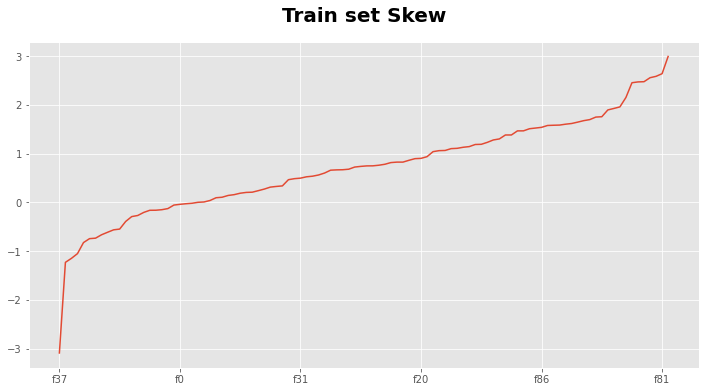

In [ ]:
plt.figure(figsize=(12,6))
train.skew().sort_values().plot()
plt.title('Train set Skew', fontsize=20, fontweight='bold', pad=20)
# noramlize를 적용 할까 고민

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = pd.concat([train.drop(columns=['id']), test.drop(columns=['id'])], axis=0)
data_columns = data.columns

for i in data.columns:
  if i == 'loss':
    continue
  data[i] = MinMaxScaler().fit_transform(data[[i]])

In [4]:
from sklearn.cluster import DBSCAN

data['cluster'] = DBSCAN(n_jobs=-1).fit_predict(data.drop(columns=['loss']))
data

KeyboardInterrupt: ignored

# Clustering 적용하자

In [5]:
!pip install catboost
!pip install optuna

     |████████████████████████████████| 67.4 MB 62 kB/s 
     |████████████████████████████████| 302 kB 9.0 MB/s 
     |████████████████████████████████| 164 kB 55.1 MB/s 
     |████████████████████████████████| 80 kB 9.9 MB/s 
     |████████████████████████████████| 75 kB 5.5 MB/s 
     |████████████████████████████████| 141 kB 62.6 MB/s 
     |████████████████████████████████| 111 kB 59.0 MB/s 
     |████████████████████████████████| 49 kB 7.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=ec3d106fd7b620e5bb8d0ee1bac7669e31a8b7ad9b18b9123b03366c0da94643
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [29]:
import catboost
import optuna
import optuna.integration.xgboost as xgbo
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneGroupOut, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [15]:
# 데이터 나누기
x_train = train.drop(columns=['id', 'loss'])
y_train = train['loss']
x_test = test.drop(columns=['id'])
x_train_columns = x_train.columns
x_test_columns = x_test.columns
x_train.shape, y_train.shape, x_test.shape

((250000, 100), (250000,), (150000, 100))

In [16]:
mm = MinMaxScaler().fit(x_train)
x_train = mm.transform(x_train)
x_test = mm.transform(x_test)

x_train = pd.DataFrame(x_train, columns=x_train_columns)
x_test = pd.DataFrame(x_test, columns=x_test_columns)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'elbow method')

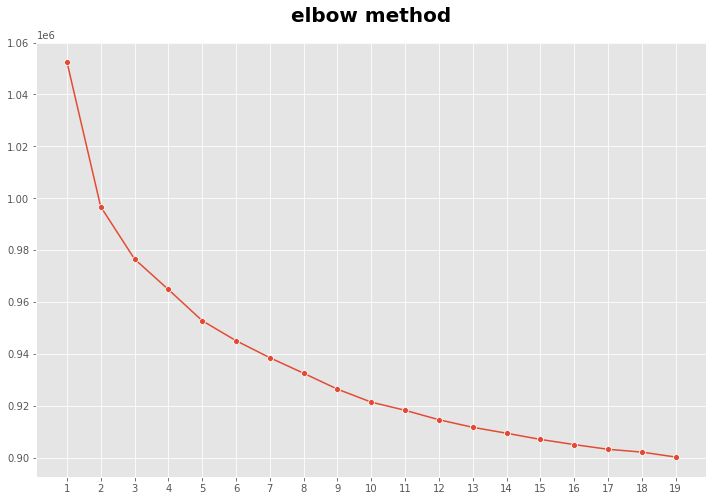

In [ ]:
# Clustering
from sklearn.cluster import KMeans

vstack = np.vstack((x_train,
                    x_test))

sse = {}
for i in range(1,20, 1):
  km = KMeans(n_clusters=i, max_iter=1000, random_state=0, n_jobs=-1).fit(vstack)
  sse[i] = km.inertia_

plt.figure(figsize=(12,8))
sns.lineplot(pd.Series(sse).index, pd.Series(sse), marker='o')
plt.xticks(pd.Series(sse).index)
plt.title('elbow method', fontsize=20, fontweight='bold', pad=20)

In [ ]:
km = KMeans(n_splits=, max_iter=1000, n_jobs=-1).fit(vstack)

x_train['cluster'] = km.predict(x_train)
x_test['cluster'] = km.predict(x_test)

# cluster DBSCAN기법

- DBSCAN(density-based spatial clustering of application with noise)은 클러스터의 갯수를 미리 지정하지 않는 군집 알고리즘


- DBSCAN은 병합 군집이나 k-평균보다는 다소 느리지만 비교적 큰 데이터셋에도 적용



- 데이터의 밀집지역이 한 클러스터를 구성하며 비교적 비어있는 지역을 경계로 다른 클러스터와 구분함



- DBSCAN은 특성 공간에서 가까이 있는 데이터가 많아 붐비는 지역의 포인트를 찾음

- 이런 지역을 밀집 지역dense region이라 함

- 밀집 지역에 있는 포인트를 핵심 포인트core point라고함



- 핵심 포인트: min_samples, epsepsilon

  - 한 데이터 포인트에서 eps 거리 안에 데이터가 min_samples 갯수만큼 들어 있으면 이 데이터 포인트를 핵심 포인트로 분류

  - eps(거리)보다 가까운 핵심 샘플은 동일한 클러스터로 분류

In [ ]:
ss = StandardScaler().fit(x_train)
x_train = mm.transform(x_train)
x_test = mm.transform(x_test)

x_train = pd.DataFrame(x_train, columns=x_train_columns)
x_test = pd.DataFrame(x_test, columns=x_test_columns)

In [11]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))

for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(iterations=3000, learning_rate=0.022, loss_function='RMSE', eval_metric='RMSE', task_type='GPU')
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += np.expm1(model_cat.predict(x_test)) / kf.n_splits

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.1039045	test: 1.1063753	best: 1.1063753 (0)	total: 10.3ms	remaining: 30.9s
100:	learn: 1.0945647	test: 1.0977858	best: 1.0977858 (100)	total: 1.8s	remaining: 51.6s
200:	learn: 1.0901819	test: 1.0942911	best: 1.0942911 (200)	total: 2.91s	remaining: 40.6s
300:	learn: 1.0869794	test: 1.0920953	best: 1.0920953 (300)	total: 4.21s	remaining: 37.7s
400:	learn: 1.0843921	test: 1.0905177	best: 1.0905177 (400)	total: 5.58s	remaining: 36.2s
500:	learn: 1.0821666	test: 1.0893155	best: 1.0893155 (500)	total: 7.41s	remaining: 37s
600:	learn: 1.0800835	test: 1.0882926	best: 1.0882926 (600)	total: 9.82s	remaining: 39.2s
700:	learn: 1.0781490	test: 1.0874149	best: 1.0874149 (700)	total: 12.1s	remaining: 39.7s
800:	learn: 1.0763697	test: 1.0866818	best: 1.0866818 (800)	total: 14.4s	remaining: 39.6s
900:	learn: 1.0746677	test: 1.0860741	best: 1.0860741 (900)	total: 16.9s	remaining: 39.3s
1000:	learn: 1.0730308	test: 1.0855342	best: 1.0855342 (1000)	total: 18.9s	remaining: 37.8s
1100:	learn: 1

In [32]:
cat_features = x_train.select_dtypes('object').columns
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,13),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
              'objective' : 'Poisson'
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [33]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-16 09:49:42,423] A new study created in memory with name: no-name-c9026779-b6f3-4dd7-ae2e-c1eaaafdfcd5
[I 2021-08-16 09:50:32,883] Trial 0 finished with value: 7.8376571884816935 and parameters: {'iterations': 7248, 'learning_rate': 0.16172459016104568, 'reg_lambda': 69.83428136890184, 'subsample': 0.1391160980040107, 'random_strength': 21.864115839196742, 'depth': 4, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 7}. Best is trial 0 with value: 7.8376571884816935.
[I 2021-08-16 09:50:55,634] Trial 1 finished with value: 8.136139044410166 and parameters: {'iterations': 14014, 'learning_rate': 0.3181192636925076, 'reg_lambda': 26.555920561362875, 'subsample': 0.9381835721450945, 'random_strength': 49.51613350724626, 'depth': 13, 'min_data_in_leaf': 26, 'leaf_estimation_iterations': 3}. Best is trial 0 with value: 7.8376571884816935.
[I 2021-08-16 09:51:10,824] Trial 2 finished with value: 7.888563271829123 and parameters: {'iterations': 6614, 'learning_rate': 0.2885902

KeyboardInterrupt: ignored

In [26]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
params = {'iterations':study.best_params['iterations'],
         'loss_function':'RMSE',
         'task_type':"GPU",
         'eval_metric':'RMSE',
         'leaf_estimation_method':'Newton',
         'bootstrap_type': 'Bernoulli',
         'learning_rate' : study.best_params['learning_rate'],
         'reg_lambda': study.best_params['reg_lambda'],
         'subsample': study.best_params['subsample'],
         'random_strength': study.best_params['random_strength'],
         'depth': study.best_params['depth'],
         'min_data_in_leaf': study.best_params['min_data_in_leaf'],
         'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
         'grow_policy' : 'Depthwise',  
}

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(**params)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += model_cat.predict(x_test) / sk.n_splits
  val_preds = model_cat.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(val_preds, Y_valid))
  print(f'{i+1}번째 RMSE:{RMSE}')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



0:	learn: 7.9395576	test: 7.9388570	best: 7.9388570 (0)	total: 31.6ms	remaining: 6m 39s
100:	learn: 7.8800936	test: 7.9139747	best: 7.9139747 (100)	total: 2.65s	remaining: 5m 29s
200:	learn: 7.8321032	test: 7.9004937	best: 7.9004937 (200)	total: 5.67s	remaining: 5m 50s
300:	learn: 7.7887435	test: 7.8904693	best: 7.8904693 (300)	total: 11.4s	remaining: 7m 46s
400:	learn: 7.7471698	test: 7.8824390	best: 7.8824390 (400)	total: 15s	remaining: 7m 35s
500:	learn: 7.7086834	test: 7.8763938	best: 7.8763938 (500)	total: 19.4s	remaining: 7m 49s
600:	learn: 7.6723829	test: 7.8709186	best: 7.8709186 (600)	total: 27.1s	remaining: 9m 1s
700:	learn: 7.6375320	test: 7.8662844	best: 7.8662844 (700)	total: 32.8s	remaining: 9m 17s
800:	learn: 7.6037303	test: 7.8626729	best: 7.8626729 (800)	total: 39.5s	remaining: 9m 43s
900:	learn: 7.5717366	test: 7.8599275	best: 7.8599275 (900)	total: 43s	remaining: 9m 19s
1000:	learn: 7.5393355	test: 7.8566437	best: 7.8566402 (999)	total: 47s	remaining: 9m 5s
1100:	lea

In [27]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
submit['loss'] = preds
submit

,id,loss
0,250000,7.818591
1,250001,4.621287
2,250002,8.178801
3,250003,7.178565
4,250004,7.017572
...,...,...
149995,399995,7.815210
149996,399996,7.295158
149997,399997,5.840186
149998,399998,5.251339


In [28]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/submit3.csv', index=False)

# To Do
* optuna integration 사용 해보기
* 다른 모델 사용